# Identify the main categories of intermittent failures

In [1]:
# imports
import re
import os
import math
import importlib
import numpy as np
import pandas as pd
import plotly.express as px

In [2]:
# global variables
config = {
    "toImageButtonOptions": {
        "format": "png",  # one of png, svg, jpeg, webp
        "filename": "noise_dist",
        "height": 400,
        "width": 500,
        "scale": 3,
    }
}

In [3]:
# global function
def read_logs(job_id, project_id):
    with open(f"../../telus-flaky-build/data/logs/{project_id}/{project_id}_{job_id}.log") as f:
        logs = f.read()
        return logs

def view_logs(job_id, project_id):
    logs = read_logs(job_id, project_id)
    print(logs)

### Load data

In [4]:
df = pd.read_csv("../data/intermittent_failures.csv")
df

,id,failure_reason,project,log
0,24005,unknown_failure,44,../../telus-flaky-build/data/logs/44/44_24005.log
1,24006,unknown_failure,44,../../telus-flaky-build/data/logs/44/44_24006.log
2,158792,script_failure,44,NaN
3,102394,script_failure,44,../../telus-flaky-build/data/logs/44/44_102394...
4,258172,script_failure,44,NaN
...,...,...,...,...
7758,447165,script_failure,1374,../../telus-flaky-build/data/logs/1374/1374_44...
7759,447168,script_failure,1374,../../telus-flaky-build/data/logs/1374/1374_44...
7760,449990,script_failure,1374,../../telus-flaky-build/data/logs/1374/1374_44...
7761,406187,script_failure,1374,../../telus-flaky-build/data/logs/1374/1374_40...


In [5]:
df[df["log"].isnull()]

,id,failure_reason,project,log
2,158792,script_failure,44,NaN
4,258172,script_failure,44,NaN
5,258184,script_failure,44,NaN
6,258185,script_failure,44,NaN
7,258196,script_failure,44,NaN
...,...,...,...,...
6523,263005,stuck_or_timeout_failure,1216,NaN
6524,263006,stuck_or_timeout_failure,1216,NaN
7000,291838,deployment_rejected,1269,NaN
7001,292328,deployment_rejected,1269,NaN


In [6]:
# keep only jobs with a log file.
df = df[~df["log"].isnull()]
print(f"{df.shape[0]} rows with a non-empty log file.")

5256 rows with a non-empty log file.


### Select two samples for study

In [7]:
# Sample size for 95% of confidence and 5% of margin error.
# https://www.surveymonkey.com/mp/sample-size-calculator/

N = df.shape[0]
z = 1.96 # z-score associated with confidence
p = 0.5  # standard deviation
e = 0.05 # margin of error

sample_size = ((z**2 * p*(1 - p)) / e**2) / (1 + ((z**2 * p*(1 - p)) / (e**2 * N)))
sample_size = math.ceil(sample_size)
sample_size

358

Generate samples of jobs

In [8]:
from src.preprocessing import log


importlib.invalidate_caches()
importlib.reload(log)

samples_included_ids = []

for i, random_state in enumerate([1, 21]):
    sample_file_path = f"../data/samples/sample{i+1}.csv"
    if os.path.isfile(sample_file_path):
        sample = pd.read_csv(sample_file_path)
    else:
        sample = df[~df["id"].isin(samples_included_ids)].sample(n=sample_size, random_state=random_state)
        sample["category"] = None
        sample["subcategory"] = None
        sample["inferred"] = False
        sample["log"] = sample.apply(lambda row: "\n".join(log.preprocess(row["project"], row["id"])), axis=1)
        sample.to_csv(sample_file_path, index=False)
    samples_included_ids.extend(sample["id"].to_list())

### Clustering sample 1 based on manual patterns

In [10]:
sample_file_path = f"../data/samples/sample1.csv"
sample = pd.read_csv(sample_file_path)
sample = sample.fillna(np.nan).replace([np.nan], [None])

patterns = pd.read_csv(f"../src/labeling/patterns_refined.csv")


def assign_category(row):
    """Infer job group and category based on manual patterns."""
    if row["group"] is not None:
        return row["group"], row["category"]
    if row["failure_reason"] == "stuck_or_timeout_failure":
        return "limits_exceeded", row["failure_reason"]
    for _, pattern in patterns.iterrows():
        logs = read_logs(row["id"], row["project"])
        if re.search(pattern["regex"], logs, flags=re.IGNORECASE) is not None:
            return pattern["group"], pattern["category"]
    return None, None


# Automatically assing jobs to categories and subcategories based on manual regex patterns
sample["group"], sample["category"] = zip(*sample.apply(assign_category, axis=1))
sample.to_csv(sample_file_path, index=False)


# Check the obtained coverage
n_labeled = sample[~sample["group"].isna()].shape[0]
print(f"{round(float(n_labeled / sample.shape[0]) * 100, 2)}% of jobs are assigned")

99.44% of jobs are assigned


In [39]:
def plot_categories(sample: str, col: str = "category"):
    sample_file_path = f"../data/samples/{sample}.csv"
    sample = pd.read_csv(sample_file_path)
    sample_copy = sample.copy(deep=True)
    sample_copy[col] = sample_copy[col].dropna(axis=0)
    categories_count = sample_copy[col].value_counts().reset_index()

    print(f"Sample size: {sample.shape[0]}")
    print(f"{categories_count.shape[0]} categories found")

    fig = px.bar(categories_count, x=col, y="count", template="simple_white")
    fig.update_layout(
        font_family="Rockwell",
        font_size=10,
        autosize=True,
        margin=dict(l=50, r=100, b=20, t=0, pad=0),
        legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.95),
        width=1200,
        height=400,
    )
    fig.update_xaxes(tickangle=45)
    fig.show(renderer="svg")

Sample size: 358
44 categories found


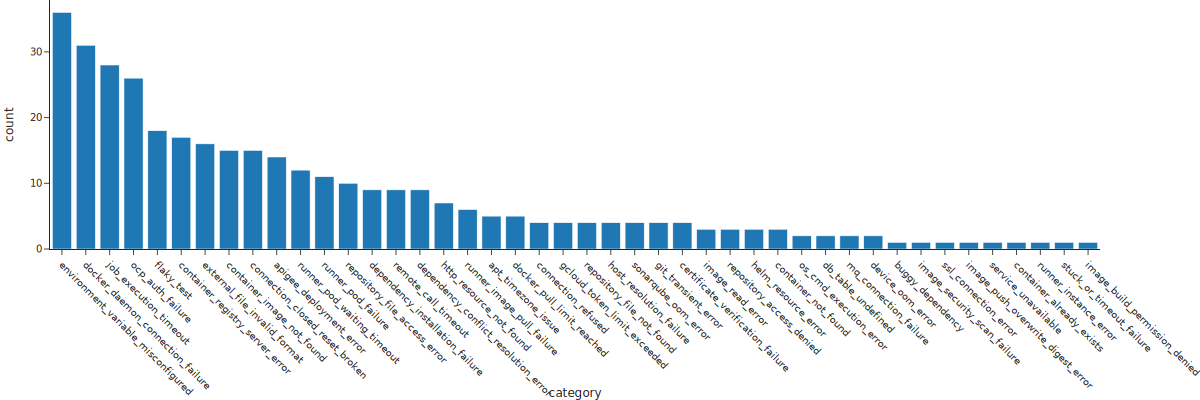

In [40]:
plot_categories("sample1")

### Inferring sample 2 categories using refined patterns

In [11]:
sample_file_path = f"../data/samples/sample2.csv"
sample = pd.read_csv(sample_file_path)
sample = sample.fillna(np.nan).replace([np.nan], [None])

patterns = pd.read_csv(f"../src/scripts/patterns_refined.csv")


def assign_category(row):
    """Infer job group and category based on manual patterns."""
    if row['group'] is not None:
        return row['group'], row['category'], row['inferred']
    if row["failure_reason"] == "stuck_or_timeout_failure":
        return "limits_exceeded", row["failure_reason"], True
    for _, pattern in patterns.iterrows():
        logs = read_logs(row["id"], row["project"])
        if re.search(pattern["regex"], logs, flags=re.IGNORECASE) is not None:
            return pattern["group"], pattern["category"], True
    return None, None, False


# Automatically assing jobs to categories and subcategories based on manual regex patterns
sample['group'], sample['category'], sample["inferred"] = zip(*sample.apply(assign_category, axis=1))
sample.to_csv(sample_file_path, index=False)


# Check the obtained coverage
n_labeled = sample[~sample["group"].isna()].shape[0]
print(f"{round(float(n_labeled / sample.shape[0]) * 100, 2)}% of jobs are assigned")

91.34% of jobs are assigned


Sample size: 358
39 categories found


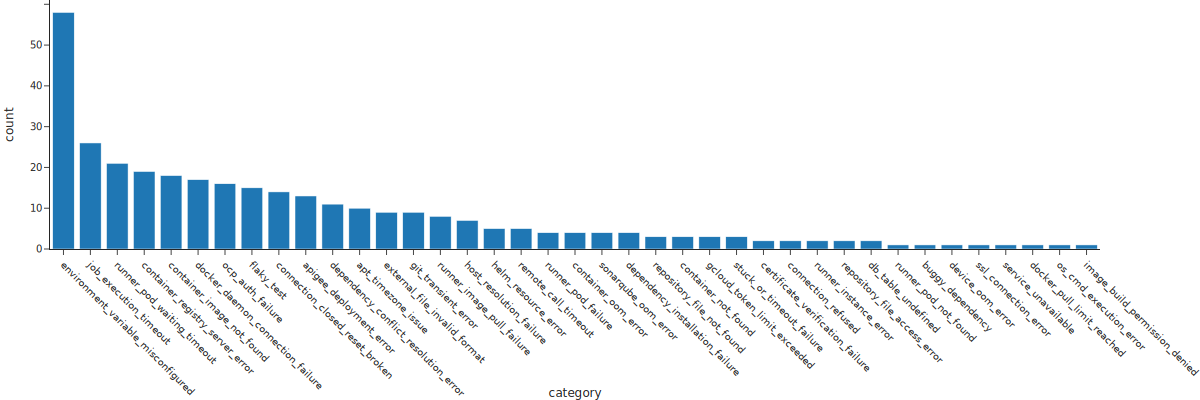

In [41]:
plot_categories("sample2") # type: ignore

In [42]:
view_logs(304327,1281)

Running with gitlab-runner 14.1.0 (8925d9a0)
  on pltf-shared-runner-c4bd5df74-xmjsn PaNmRfmj
section_start:1686759194:resolve_secrets
Resolving secrets
section_end:1686759194:resolve_secrets
section_start:1686759194:prepare_executor
Preparing the "kubernetes" executor
Using Kubernetes namespace: plt-gitlab-runners
Using Kubernetes executor with image image-registry.openshift-image-registry.svc:5000/openshift/uapi-gw-alpine:develop ...
Using attach strategy to execute scripts...
section_end:1686759194:prepare_executor
section_start:1686759194:prepare_script
Preparing environment
Waiting for pod plt-gitlab-runners/runner-panmrfmj-project-1281-concurrent-0mngbf to be running, status is Pending
Waiting for pod plt-gitlab-runners/runner-panmrfmj-project-1281-concurrent-0mngbf to be running, status is Pending
	ContainersNotReady: "containers with unready status: [build helper]"
	ContainersNotReady: "containers with unready status: [build helper]"
Running on runner-panmrfmj-project-1281-conc

### Sample dataset creation

In [43]:
sample1 = pd.read_csv("../data/samples/sample1.csv")
sample2 = pd.read_csv("../data/samples/sample2.csv")
sample = pd.concat([sample1, sample2], axis=0)

sample.drop(columns=["group", "failure_reason", "inferred"], inplace=True)
sample = sample[~sample["category"].isnull()]

sample["log"] = sample.apply(lambda row: read_logs(row["id"], row["project"]), axis=1)
sample.to_csv(f"../data/labeled_sample.csv", index=False)

### Labeling intermittent failures using refined patterns

In [44]:
df.head(3)

,id,failure_reason,project,log
0,24005,unknown_failure,44,../../telus-flaky-build/data/logs/44/44_24005.log
1,24006,unknown_failure,44,../../telus-flaky-build/data/logs/44/44_24006.log
3,102394,script_failure,44,../../telus-flaky-build/data/logs/44/44_102394...


In [45]:
df.shape

(5256, 4)

In [47]:
from timeit import default_timer as timer

df_copy = df.copy(deep=True)
df_copy["group"] = None
df_copy["category"] = None

patterns = pd.read_csv(f"../src/labeling/patterns_refined.csv")

def assign_category(row):
    """Infer job group and category based on manual patterns."""
    if row["group"] is not None:
        return row['group'], row['category']
    if row["failure_reason"] == "stuck_or_timeout_failure":
        return "limits_exceeded", row["failure_reason"]
    for _, pattern in patterns.iterrows():
        logs = read_logs(row["id"], row["project"])
        if re.search(pattern["regex"], logs, flags=re.IGNORECASE) is not None:
            return pattern["group"], pattern["category"]
    return None, None


# Automatically assing jobs to categories and subcategories based on manual regex patterns
start = timer()
df_copy['group'], df_copy['category'] = zip(*df_copy.apply(assign_category, axis=1))
duration = timer() - start

df_copy[~df_copy['category'].isnull()].to_csv("../data/labeled_intermittent_failures.csv", index=False)


# Check the obtained coverage
n_labeled = df_copy[~df_copy["group"].isna()].shape[0]
print(f"{round(float(n_labeled / df_copy.shape[0]) * 100, 2)}% of jobs are assigned in {duration}s")

85.83% of jobs are assigned in 2644.472333360929s
